In [1]:
from datetime import datetime as dt

dt.now()

datetime.datetime(2017, 6, 11, 12, 5, 44, 118427)

This is modified version of *_all_realigned using photutils.find_peaks for better realignment 

In [2]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [3]:
!conda env list

# conda environments:
#
GoogEarthEngine          /home/jp/miniconda2/envs/GoogEarthEngine
astroconda               /home/jp/miniconda2/envs/astroconda
everest-pipeline         /home/jp/miniconda2/envs/everest-pipeline
helios                   /home/jp/miniconda2/envs/helios
iraf27                *  /home/jp/miniconda2/envs/iraf27
ircs_pol                 /home/jp/miniconda2/envs/ircs_pol
moscatel                 /home/jp/miniconda2/envs/moscatel
radmc3dpy                /home/jp/miniconda2/envs/radmc3dpy
root                     /home/jp/miniconda2



## skysubtraction (next dither)

In [4]:
import glob
import getpass
import os
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

skysub_ch1 = glob.glob('*fgs_ch1.fits')
skysub_ch1.sort()
skysub_ch2 = glob.glob('*fgs_ch2.fits')
skysub_ch2.sort()

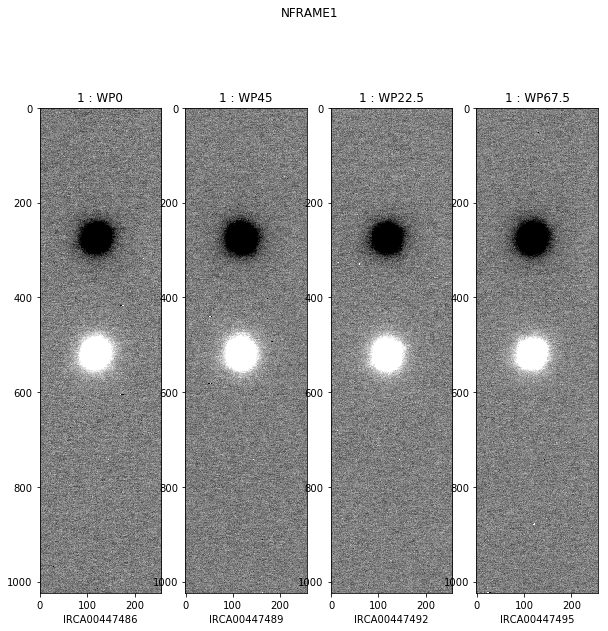

In [5]:
from astropy.visualization import ZScaleInterval
interval= ZScaleInterval()

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
idx=0
nframes=3
wpangle=4

#dither 1
for i in skysub_ch1[:nframes*wpangle][::nframes]:
    hdr = pf.getheader(i) #[i+1] for nframe2
    img = pf.getdata(i) #[i+1] for nframe2
    vmin, vmax = interval.get_limits(img)
    ax[idx].imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
    plt.suptitle('NFRAME1')
    if isinstance(hdr['I_DTHPOS'], str): 
        ax[idx].set_title(hdr['I_DTHPOS'])
        ax[idx].set_xlabel(hdr['FRAMEID'])
    else:
        pass
    idx+=1

## combine I images (dither 1)

In [6]:
I = {}

for i in range(len(skysub_ch1)):
    hdr = pf.getheader(skysub_ch1[i])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i])
    img2 = pf.getdata(skysub_ch2[i])
    I[i] = img1 + img2
    #print(hdr)

In [7]:
#I.keys()
#split I into each nframe: 20 I image each dict
I1 = {}
I2 = {}
I3 = {}

for m,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i])['I_DTHPOS']
    #ch1
    img1 = pf.getdata(skysub_ch1[i])
    #ch2
    img2 = pf.getdata(skysub_ch2[i])
    I1[m] = img1 + img2

for n,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr2 = pf.getheader(skysub_ch1[i+1])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+1])
    img2 = pf.getdata(skysub_ch2[i+1])
    I2[n] = img1 + img2
    
for o,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i+2])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+2])
    img2 = pf.getdata(skysub_ch2[i+2])
    I3[o] = img1 + img2
    
I1.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

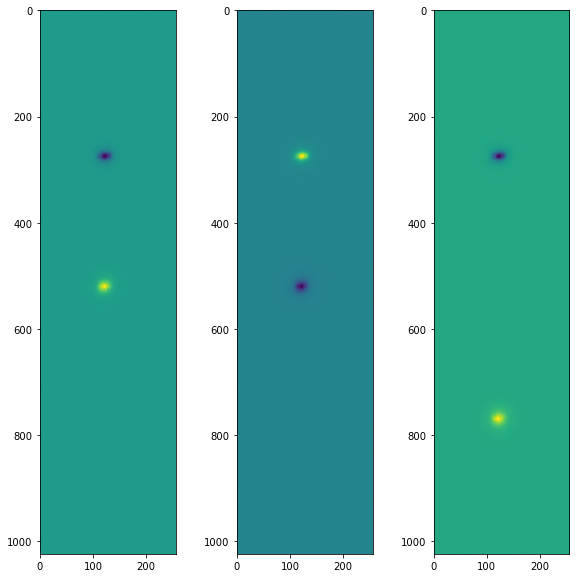

In [8]:
fig, ax = plt.subplots(1,3,figsize=(10,10))

#dither 1 to 5
xest = (90,120)
yest = [(500,530), (205,235), (350,380), (645,675), (795,825)]

#nframe 1
for i,j in enumerate(I1.keys()[::4]): #only first set
    #vmin, vmax = interval.get_limits(I1[j])
    ax[i].imshow(I1[j])#, vmin=vmin, vmax=vmax)
    #ax[i].set_xlim(xest)
    #ax[i].set_ylim(yest[i])

### shifting image

#### find centroid

In [33]:
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks

def get_centroid(data):
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    threshold = median + (10.0 * std)
    tbl = find_peaks(data, threshold, box_size=5)
    #limit location of x and y
    half=data.shape[1]/2
    xlim = [i for i,(j,k) in enumerate(zip(tbl['x_peak'],tbl['y_peak'])) if half-20 < j < half+20 and 200 < k < 800]
    
    try:
        for idx in xlim:
            #get index of brightest source within the limit
            if tbl['peak_value'][idx] == max(tbl[xlim]['peak_value']):
                #import pdb; pdb.set_trace()
                x_max, y_max = int(tbl['x_peak'][idx]), int(tbl['y_peak'][idx])
    except:
        x_max, y_max = 100,100
        print('no centroid')
    return (x_max, y_max)#tuple

In [34]:
from tqdm import tqdm

centroids_ch1, centroids_ch2  = [], []

for i in tqdm(skysub_ch1):
    data = pf.getdata(i)
    x_max, y_max = get_centroid(data)
    centroids_ch1.append((x_max, y_max))
    
for j in tqdm(skysub_ch2):
    data = pf.getdata(j)
    x_max, y_max = get_centroid(data)
    centroids_ch2.append((x_max, y_max))

100%|██████████| 36/36 [00:07<00:00,  5.06it/s]


In [37]:
def get_crop(image, centroid, box_size):
    '''
    simple cropping tool
    '''
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])
    return image_crop

In [38]:
I1_shifted = {}
I2_shifted = {}
I3_shifted = {}

for m,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i])['I_DTHPOS']
    #ch1
    img1 = pf.getdata(skysub_ch1[i])
    img2 = pf.getdata(skysub_ch2[i])
    #instead of shifting, crop at centroid
    img1_crop = get_crop(img1, centroids_ch1[i], box_size=200)
    img2_crop = get_crop(img2, centroids_ch2[i], box_size=200)
    I1_shifted[m] = img1_crop + img2_crop 

for n,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr2 = pf.getheader(skysub_ch1[i+1])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+1])
    img2 = pf.getdata(skysub_ch2[i+1])
    img1_crop = get_crop(img1, centroids_ch1[i], box_size=200)
    img2_crop = get_crop(img2, centroids_ch2[i], box_size=200)
    I2_shifted[n] = img1_crop + img2_crop
    
for o,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i+2])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+2])
    img2 = pf.getdata(skysub_ch2[i+2])
    img1_crop = get_crop(img1, centroids_ch1[i], box_size=200)
    img2_crop = get_crop(img2, centroids_ch2[i], box_size=200)
    I3_shifted[o] = img1_crop + img2_crop

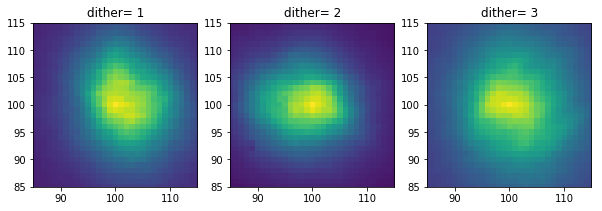

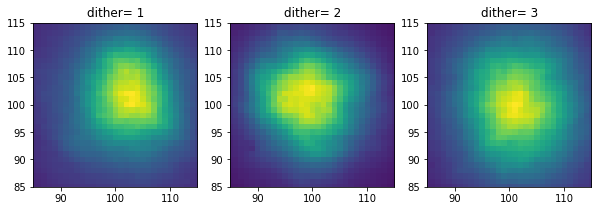

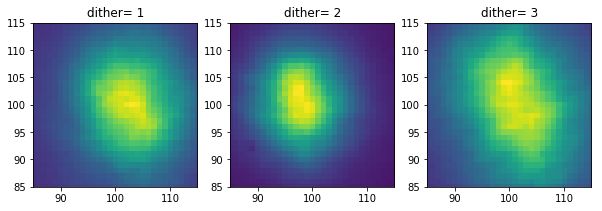

In [41]:
from astropy.visualization import ZScaleInterval
interval= ZScaleInterval()

fig, ax = plt.subplots(1,dither,figsize=(10,10))
n1,n2=85,115
dither=3
#nframe 1
for i,j in enumerate(I1.keys()[::4]): #only first set
    #vmin, vmax = interval.get_limits(I1_shifted[j])
    ax[i].imshow(I1_shifted[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_xlim([n1,n2])
    ax[i].set_ylim([n1,n2])
    ax[i].set_title('dither= {}'.format(i+1))

fig, ax = plt.subplots(1,dither,figsize=(10,10))
#nframe 2
for i,j in enumerate(I2.keys()[::4]): #only first set
    #vmin, vmax = interval.get_limits(I2_shifted[j])
    ax[i].imshow(I2_shifted[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_xlim([n1,n2])
    ax[i].set_ylim([n1,n2])
    ax[i].set_title('dither= {}'.format(i+1))
    
fig, ax = plt.subplots(1,dither,figsize=(10,10))
#nframe 3
for i,j in enumerate(I3.keys()[::4]): #only first set
    #vmin, vmax = interval.get_limits(I3_shifted[j])
    ax[i].imshow(I3_shifted[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_xlim([n1,n2])
    ax[i].set_ylim([n1,n2])
    ax[i].set_title('dither= {}'.format(i+1))

sum every first four image (=one WP cycle) in each I1, I2, I3 (i.e. nframe 1,2,3) to get Itot per dither.

## Combine aligned I image (I_shifted) per WP cycle: Itot

In [42]:
Itot1={} #nframe1 with 5 dithered images
Itot2={}
Itot3={}

#nframe 1: dither 1 to 5
for i,j in enumerate(I1_shifted.keys()[::4]):
    Itot1[i]=[]
    Itot1[i].append(I1_shifted[j])
    print(i,j)
    Itot1[i].append(I1_shifted[j+1])
    print(i,j+1)
    Itot1[i].append(I1_shifted[j+2])
    print(i,j+2)
    Itot1[i].append(I1_shifted[j+3])
    print(i,j+3)
    
#nframe 2: dither 1 to 5
for i,j in enumerate(I2_shifted.keys()[::4]): 
    Itot2[i]=[]
    Itot2[i].append(I2_shifted[j])
    Itot2[i].append(I2_shifted[j+1])
    Itot2[i].append(I2_shifted[j+2])
    Itot2[i].append(I2_shifted[j+3])
    
#nframe 3: dither 1 to 5
for i,j in enumerate(I3_shifted.keys()[::4]):
    Itot3[i]=[]
    Itot3[i].append(I3_shifted[j])
    Itot3[i].append(I3_shifted[j+1])
    Itot3[i].append(I3_shifted[j+2])
    Itot3[i].append(I3_shifted[j+3])

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)


In [44]:
np.array(Itot1[0]).shape

for i in Itot1.keys():
    Itot1[i]=np.median(Itot1[i],axis=0)
    Itot2[i]=np.median(Itot2[i],axis=0)
    Itot3[i]=np.median(Itot3[i],axis=0)

after stacking,

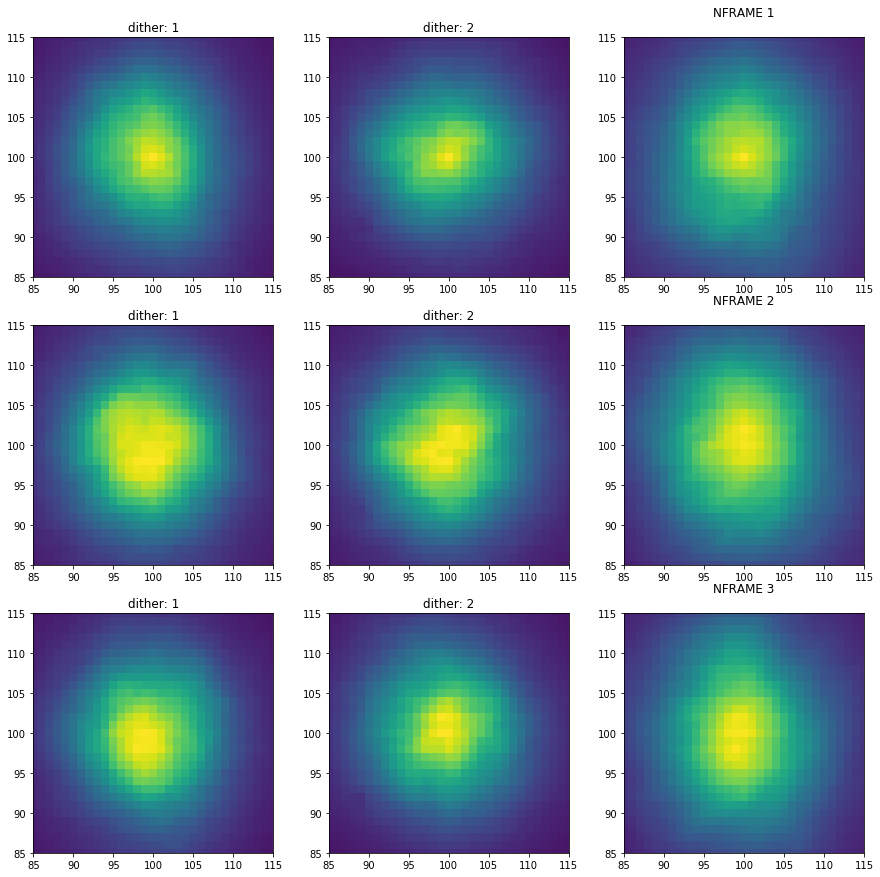

In [46]:
dither=3
fig, ax = plt.subplots(nrows=3, ncols=dither, figsize=(15,15))

n1,n2=85,115
for n,key in enumerate(Itot1.keys()):
    vmin1, vmax1 = interval.get_limits(Itot1[key])
    vmin2, vmax2 = interval.get_limits(Itot2[key])
    vmin3, vmax3 = interval.get_limits(Itot2[key])
    
    #Itot1: nframe1
    ax[0,n].imshow(Itot1[key])#, vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    ax[0,n].set_xlim([n1,n2])
    ax[0,n].set_ylim([n1,n2])
    #Itot2: nframe2
    ax[1,n].imshow(Itot2[key])#, vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    ax[1,n].set_xlim([n1,n2])
    ax[1,n].set_ylim([n1,n2])
    #Itot3 nframe3
    ax[2,n].imshow(Itot3[key])#, vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    ax[2,n].set_xlim([n1,n2])
    ax[2,n].set_ylim([n1,n2])
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

In [47]:
Q1 = {}
Q2 = {}
Q3 = {}
U1 = {}
U2 = {}
U3 = {}

#nframe 1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    Q1[h]=I1_shifted[i]-I1_shifted[i+1]
    #5 U images each nframe
    print(i+2,i+3)
    U1[h]=I1_shifted[i+2]-I1_shifted[i+3]
    
#nframe 2
for h,j in enumerate(range(len(I2_shifted))[::4]):
    Q2[h]=I2_shifted[j]-I2_shifted[j+1]
    U2[h]=I2_shifted[j+2]-I2_shifted[j+3]
    
#nframe 3
for h,k in enumerate(range(len(I3))[::4]):
    Q3[h]=I3_shifted[k]-I3_shifted[k+1]
    U3[h]=I3_shifted[k+2]-I3_shifted[k+3]
    

(0, 1)
(2, 3)
(4, 5)
(6, 7)
(8, 9)
(10, 11)


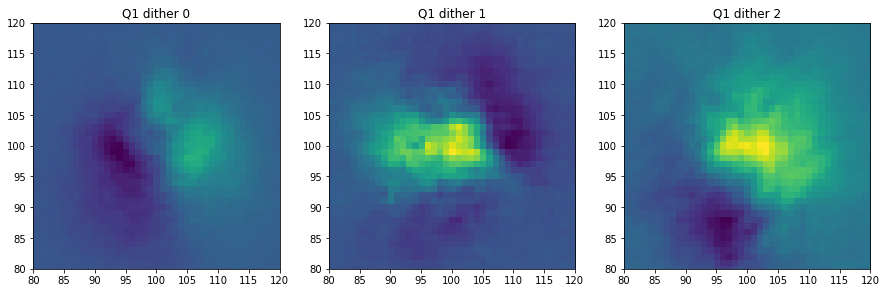

In [48]:
dither=3
fig, ax = plt.subplots(1,dither,figsize=(15,10))

#nframe 1
m,n=20,100
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

## using cross-correlation shifts to realign Q and U

In [49]:
import image_registration as im_reg
from scipy.ndimage.interpolation import shift

Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    dy, dx = im_reg.cross_correlation_shifts(wp0, wp45, maxoff=4, return_error=False, zeromean=True)
    print('dy={0:.2f}, dx={1:.2f}'.format(dy, dx))
    #aligned_ch3 = np.roll(np.roll(im3,int(yoff),1),int(xoff),0) #shift based on calculated centroid
    shifted = shift(wp0, shift=(dy, dx))
    Q1_shifted[h]=I1_shifted[i+1] - shifted

(0, 1)
dy=-3.06, dx=-1.07
(4, 5)
dy=1.34, dx=0.36
(8, 9)
dy=-2.99, dx=-2.99


subpixel shifts does not minimize residual as shown on the bottom

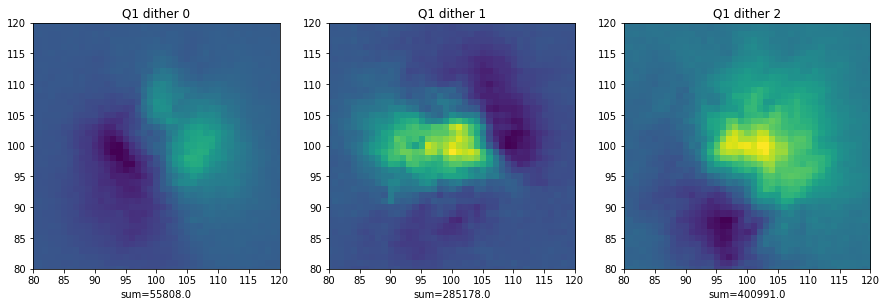

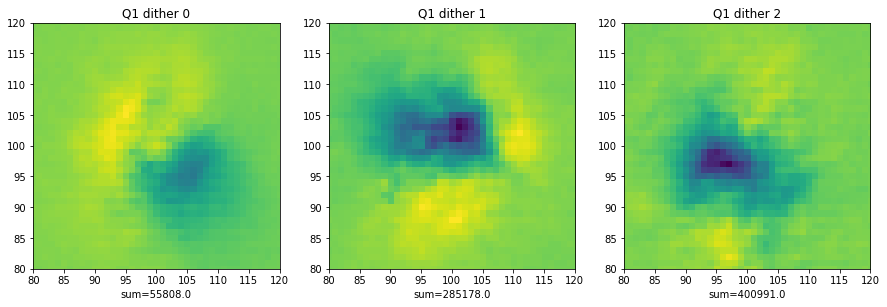

In [51]:
dither=3
fig, ax = plt.subplots(1,dither,figsize=(15,10))

#nframe 1
m,n=20,100
for i,j in enumerate(Q1.keys()): #only first set
    #vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i))
    ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

#shifted
fig, ax = plt.subplots(1,dither,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    #vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j])#, vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i))
    ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

### random shifting to produce smallest residuals

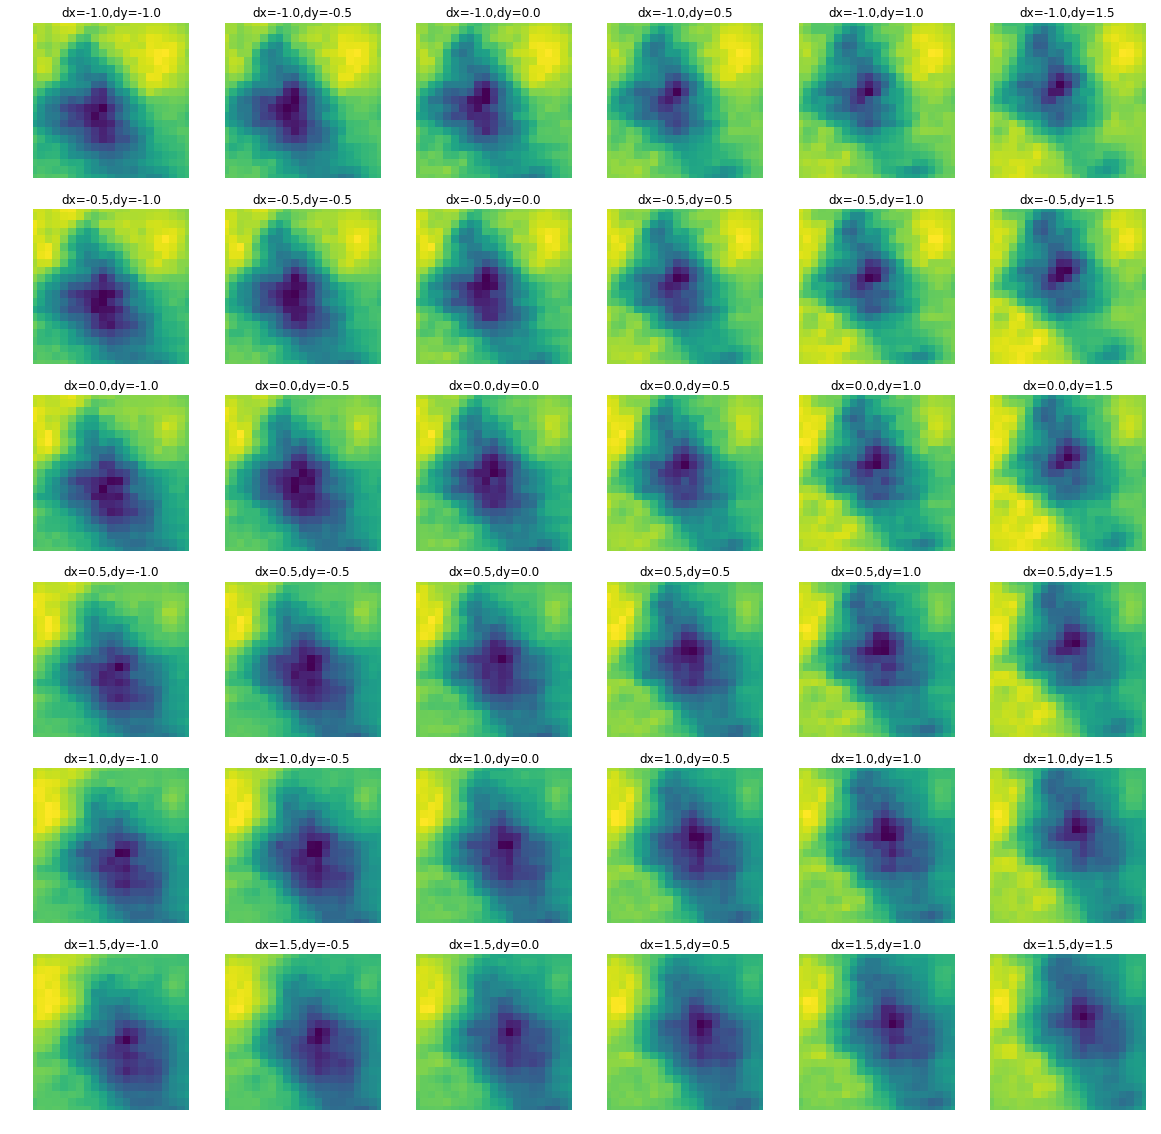

In [54]:
from scipy.linalg import norm


ylims = xlims=[90,110]


def minimize_residual(img1, img2, show_fig=False):
    residuals = {}
    diff = {}
    dx=dy=np.arange(-1,2,0.5)
    if show_fig==True:
        fig, ax = plt.subplots(nrows=len(dx), ncols=len(dy), figsize=(20,20))
    for k,i in enumerate(dx):
        for l,j in enumerate(dy):
            img2_shifted = shift(img2, shift=(j, i), mode='wrap')
            diff[str(i)+','+str(j)] = img1 - img2_shifted
            #compute L2 norm
            residuals[str(i)+','+str(j)] = norm(diff[str(i)+','+str(j)], ord=2) #has same result as np.std()
            if show_fig==True:
                ax[k,l].imshow(diff[str(i)+','+str(j)])
                ax[k,l].set_xlim(xlims)
                ax[k,l].set_ylim(ylims)
                ax[k,l].set_axis_off()
                ax[k,l].set_title('dx={0:.1f},dy={1:.1f}'.format(i,j))
                
            
    #get smallest flux
    min_flux = np.min([residuals[k] for k in residuals.keys()])
    #get indices of shifts with minimum flux (dy,dx)
    idx = [k for k in residuals.keys() if residuals[k] == min_flux]
    #get image with smallest residual
    img = diff[idx[0]]
    return (img, idx[0]) #dict of images


#wp0 and wp45
img1=I1_shifted[2]
img2=I1_shifted[3]

(img, shift_xy) = minimize_residual(img1, img2, show_fig=True)

In [55]:
shift_xy

'-0.5,1.0'

test

In [56]:
Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

#nframe1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    print('dx,dy={}'.format(Qshift_xy))
    Q1_shifted[h]= Qimg
    #shift to make U
    print(i+2,i+3)
    wp225=I1_shifted[i+2]
    wp675=I1_shifted[i+3]
    '''
    #U must be shifted independently from Q
    dx, dy = shift_xy[0], shift_xy[1]
    wp675_shifted = shift(wp675, shift=(int(dy), int(dx)))
    U1_shifted[h]= wp225 - wp675_shifted '''
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    print('dx,dy={}'.format(Ushift_xy))
    U1_shifted[h]= Uimg

#nframe2
for h,i in tqdm(enumerate(range(len(I2_shifted))[::4])):
    #print(i,i+1)
    wp0=I2_shifted[i]
    wp45=I2_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q2_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I2_shifted[i+2]
    wp675=I2_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U2_shifted[h]= Uimg
    
#nframe3
for h,i in tqdm(enumerate(range(len(I3_shifted))[::4])):
    #print(i,i+1)
    wp0=I3_shifted[i]
    wp45=I3_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q3_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I3_shifted[i+2]
    wp675=I3_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U3_shifted[h]= Uimg
    
print('---DONE---')

(0, 1)
dx,dy=1.5,-0.5
(2, 3)
dx,dy=-0.5,1.0
(4, 5)
dx,dy=-1.0,0.0
(6, 7)
dx,dy=-1.0,-1.0
(8, 9)
dx,dy=1.5,1.5
(10, 11)


0it [00:00, ?it/s]

dx,dy=-1.0,-0.5


3it [00:02,  1.32it/s]
3it [00:02,  1.30it/s]

---DONE---


shifted Q comparison

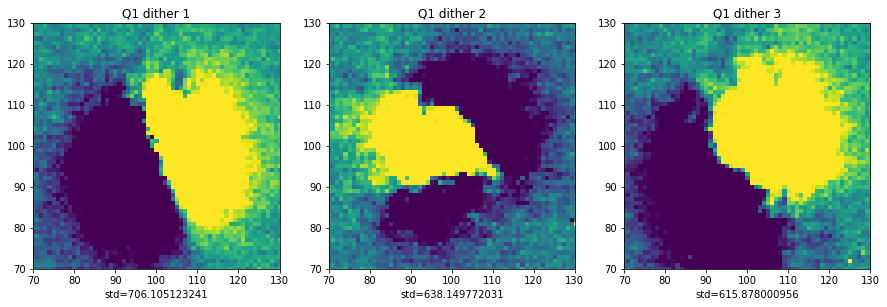

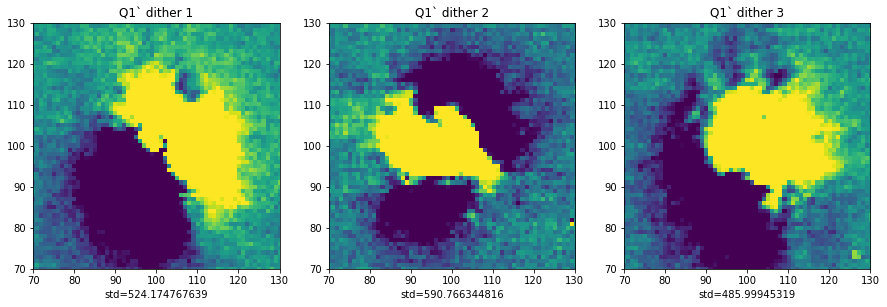

In [60]:
dither=3
fig, ax = plt.subplots(1,dither,figsize=(15,10))

#nframe 1
n=100
m=30
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(norm(Q1[j],2)))
    ax[i].set_xlabel('std={}'.format(np.std(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,dither,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.std(Q1_shifted[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

shifted U comparison

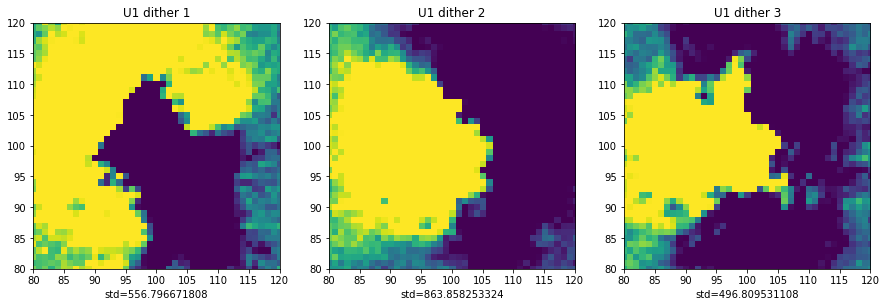

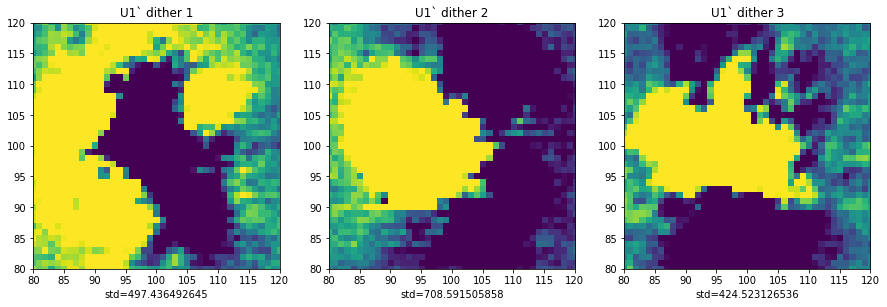

In [62]:
dither=3
fig, ax = plt.subplots(1,dither,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(U1.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlabel('std={}'.format(np.std(U1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,dither,figsize=(15,10))
for i,j in enumerate(U1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.std(U1_shifted[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

In [67]:
PI1={}
PI2={}
PI3={}

for i,q in enumerate(Q1.keys()):
    #5 PI image each nframe
    PI1[i]=np.sqrt(Q1_shifted[q]**2+U1_shifted[q]**2)
    PI2[i]=np.sqrt(Q2_shifted[q]**2+U2_shifted[q]**2)
    PI3[i]=np.sqrt(Q3_shifted[q]**2+U3_shifted[q]**2)

## Q

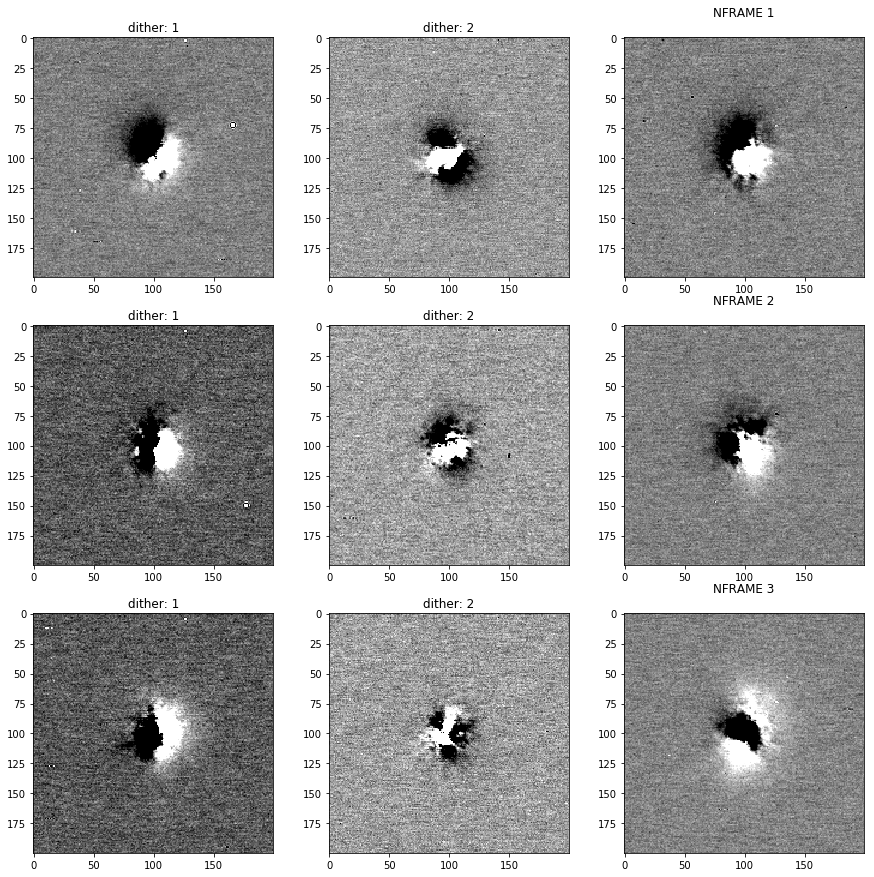

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=dither, figsize=(15,15))

for n,key in enumerate(Q1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(Q1_shifted[key])
    vmin2, vmax2 = interval.get_limits(Q2_shifted[key])
    vmin3, vmax3 = interval.get_limits(Q2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(Q1_shifted[key], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(Q2_shifted[key], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(Q3_shifted[key], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## U

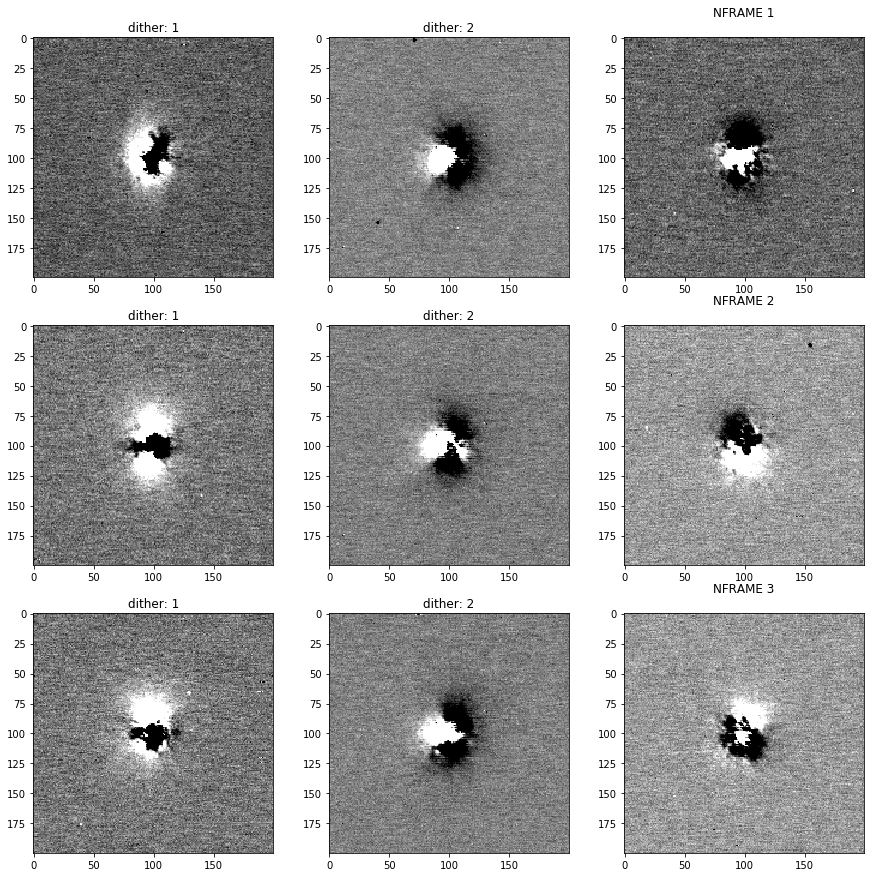

In [72]:
nframe=3
fig, ax = plt.subplots(nrows=nframe, ncols=dither, figsize=(15,15))

for n,key in enumerate(U1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(U1_shifted[key])
    vmin2, vmax2 = interval.get_limits(U2_shifted[key])
    vmin3, vmax3 = interval.get_limits(U2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(U1_shifted[key], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(U2_shifted[key], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(U3_shifted[key], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## PI

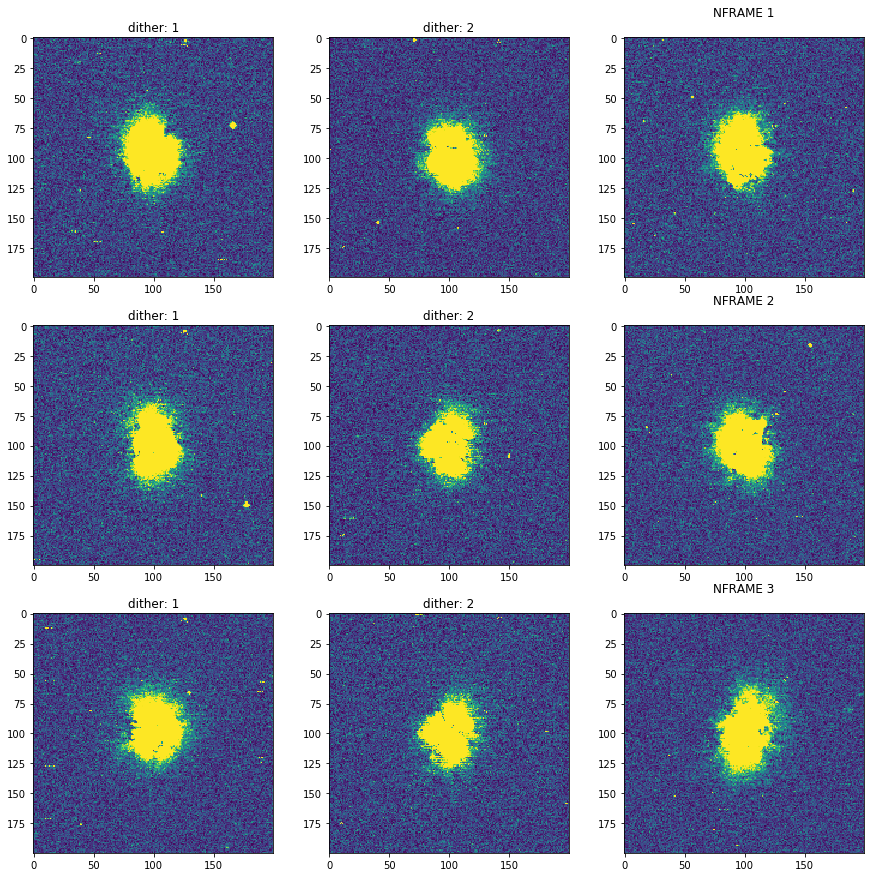

In [74]:
fig, ax = plt.subplots(nrows=nframe, ncols=dither, figsize=(15,15))

for i in range(dither):
    vmin1, vmax1 = interval.get_limits(PI1[i])
    vmin2, vmax2 = interval.get_limits(PI2[i])
    vmin3, vmax3 = interval.get_limits(PI3[i])
    
    ax[0,i].imshow(PI1[i], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,i].set_title('dither: {}'.format(i+1))
    ax[1,i].imshow(PI2[i], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,i].set_title('dither: {}'.format(i+1))
    ax[2,i].imshow(PI3[i], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,i].set_title('dither: {}'.format(i+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## median combined I, Q, U, PI (per dither)

In [75]:
Itot_med = {}
for n,key in enumerate(Itot1.keys()):
    Itot_med[n] = []
    #dither 1
    Itot_med[n].append(Itot1[key])
    Itot_med[n].append(Itot2[key])
    Itot_med[n].append(Itot3[key])
    #stack
    Itot_med[n]=np.median(Itot_med[n],axis=0)

Q_med = {}
for n,key in enumerate(Q1_shifted.keys()):
    Q_med[n] = []
    #dither 1
    Q_med[n].append(Q1_shifted[key])
    Q_med[n].append(Q2_shifted[key])
    Q_med[n].append(Q3_shifted[key])
    #stack
    Q_med[n]=np.median(Q_med[n],axis=0)
    
U_med = {}
for n,key in enumerate(U1_shifted.keys()):
    U_med[n] = []
    #dither 1
    U_med[n].append(U1_shifted[key])
    U_med[n].append(U2_shifted[key])
    U_med[n].append(U3_shifted[key])
    #stack
    U_med[n]=np.median(U_med[n],axis=0)
    
PI_med = {}
for n,key in enumerate(PI1.keys()):
    PI_med[n] = []
    #dither 1
    PI_med[n].append(PI1[key])
    PI_med[n].append(PI2[key])
    PI_med[n].append(PI3[key])
    #stack
    PI_med[n]=np.median(PI_med[n],axis=0)

## Stacked I, Q,U, & PI per dither

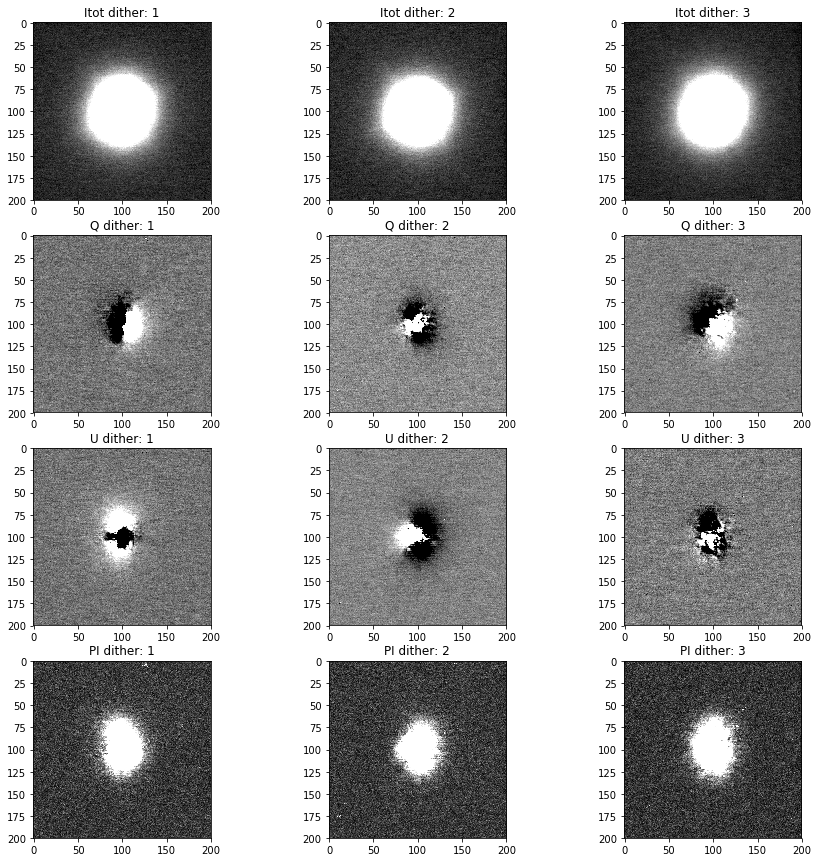

In [78]:
fig, ax = plt.subplots(nrows=4, ncols=dither, figsize=(15,15))

for i in range(dither):
    vmin0, vmax0 = interval.get_limits(Itot_med[i])
    vmin1, vmax1 = interval.get_limits(Q_med[i])
    vmin2, vmax2 = interval.get_limits(U_med[i])
    vmin3, vmax3 = interval.get_limits(PI_med[i])
    
    ax[0,i].imshow(Itot_med[i], vmin=vmin0, vmax=vmax0, cmap='gray')
    ax[0,i].set_title('Itot dither: {}'.format(i+1))
    ax[1,i].imshow(Q_med[i], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[1,i].set_title('Q dither: {}'.format(i+1))
    ax[2,i].imshow(U_med[i], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[2,i].set_title('U dither: {}'.format(i+1))
    ax[3,i].imshow(PI_med[i], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[3,i].set_title('PI dither: {}'.format(i+1))

## Combine dithered Itot, Q, U, PI

In [80]:
Itot_med_final = []
Q_med_final = []
U_med_final = []
PI_med_final = []

for i in range(dither):
    #combine per dither
    Itot_med_final.append(Itot_med[i])
    Q_med_final.append(Q_med[i])
    U_med_final.append(U_med[i])
    PI_med_final.append(PI_med[i])

Itot_med_final = np.median(Itot_med_final, axis=0)
Q_med_final = np.median(Q_med_final, axis=0)
U_med_final = np.median(U_med_final, axis=0)
PI_med_final = np.median(PI_med_final, axis=0)

## previous results

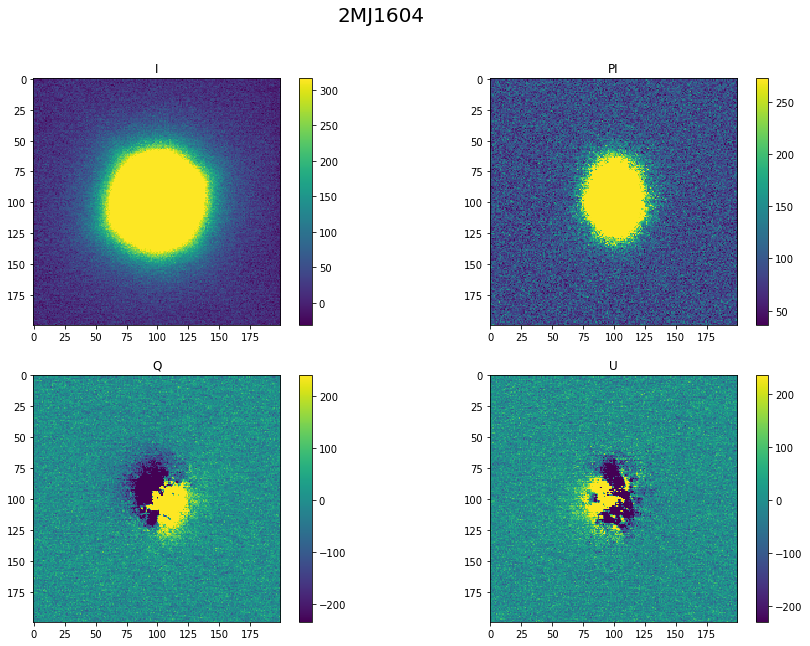

In [81]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

vmin0, vmax0 = interval.get_limits(Itot_med_final)
vmin1, vmax1 = interval.get_limits(PI_med_final)
#vmin1, vmax1 = interval.get_limits(PI_crop/I_crop)
vmin2, vmax2 = interval.get_limits(Q_med_final)
vmin3, vmax3 = interval.get_limits(U_med_final)

ax1 = ax[0,0].imshow(Itot_med_final, vmin=vmin0, vmax=vmax0)
ax[0,0].set_title('I')
fig.colorbar(ax1, ax=ax[0,0])#, orientation='horizontal')
#ax2 = ax[0,1].imshow(PI_crop/I_crop, vmin=vmin1, vmax=vmax1)
ax2 = ax[0,1].imshow(PI_med_final, vmin=vmin1, vmax=vmax1)
fig.colorbar(ax2, ax=ax[0,1])
#ax[0,1].set_title('PI/I')
ax[0,1].set_title('PI')
ax3 = ax[1,0].imshow(Q_med_final, vmin=vmin2, vmax=vmax2)
fig.colorbar(ax3, ax=ax[1,0])
ax[1,0].set_title('Q')
ax4 = ax[1,1].imshow(U_med_final, vmin=vmin3, vmax=vmax3)
fig.colorbar(ax4, ax=ax[1,1])
ax[1,1].set_title('U')
plt.suptitle(pf.getheader(skysub_ch1[0])['OBJECT'], fontsize=20)
#plt.tight_layout()
# ax[0,0].imshow(np.log(I_crop))
# ax[0,1].imshow(np.log(PI_crop))
# ax[1,0].imshow(np.log(Q_crop))
# ax[1,1].imshow(np.log(U_crop))

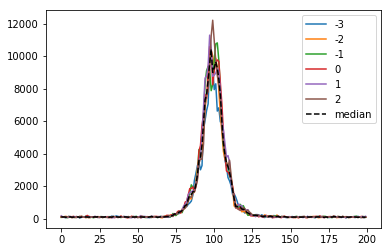

In [82]:
xslices=[]
for i in np.arange(-3,3,1):
    xslice=PI_med_final[PI_med_final.shape[1]/2+i,:]
    plt.plot(xslice, label=i)
    xslices.append(xslice)

xslice=np.median(xslices,axis=0)
plt.plot(xslice, 'k--', label='median')
plt.legend()

## estimating FWHM

A: 94.3504121254
mu: 99.1794450351
sigma= 6.38779159378
eps: 1.42948889168
est_fwhm= 15.0432492034


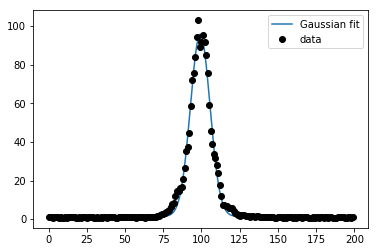

In [88]:
#using scipy
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

#normalized
ydata = xslice/np.median(xslice)
xdata = np.array(range(len(ydata)))
xcen = len(xdata)/2
sigma = np.std(ydata)
#fitting
eps =0
popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [1, xcen, sigma, eps])

plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
plt.plot(xdata,ydata,'ok', label='data')
plt.legend()

est_fwhm=2.355*np.abs(popt[2])
print('A: {}\nmu: {}\nsigma= {}\neps: {}\nest_fwhm= {}'.format(popt[0],popt[1], popt[2], popt[3], est_fwhm))


## Polarization vectors

In [118]:
from scipy.ndimage.filters import gaussian_filter
from numpy import *
import matplotlib.pyplot as pl

# Pol=100 % max_length=in pixel

### Classes and Modules ###
class Linear_pol_vector:
    def __init__(self,x,y,I,Q,U,ax,max_length=10,linewidth=2,color='b'):
        self.x=x
        self.y=y
        self.I=I
        self.Q=Q
        self.U=U
        self.ax=ax
        self.max_length=max_length
        self.P=sqrt(Q**2+U**2)/I
        if self.P == 0:
            self.pl,=ax.plot([self.x,self.x],[self.y,self.y],linestyle='-',color=color,
                       linewidth=2)
        else:
            self.ang=arctan2(self.U,self.Q)*0.5
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl,=ax.plot([self.x-dx,self.x+dx],[self.y-dy,self.y+dy], linestyle='-',color=color,linewidth=2)
    def change_max_length(self,max_length=10):
        if self.P != 0:
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl.set_xdata=[self.x-dx,self.x+dx]
            self.pl.set_ydata=[self.y-dy,self.y+dy]
    def reset(self):
        self.change_max_length()
        self.pl.set_linewidth=2
        self.pl.set_color='w'

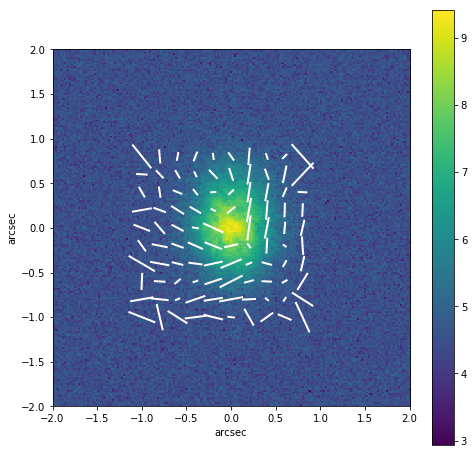

In [140]:
scale= 0.020 #ircs_pix_size: mas/pix
box_size = 200

#xcenter = int(sources['xcentroid'][2])
#ycenter = int(sources['ycentroid'][2])
xcenter = ycenter = box_size/2.0

#convert to AU by multiplying arsec with parsec
#x_in_AU=(np.arange(box_size)-xcenter)*scale*distance
#y_in_AU=(np.arange(box_size)-ycenter)*scale*distance

x_in_as=(np.arange(box_size)-xcenter)*scale
y_in_as=(np.arange(box_size)-ycenter)*scale

img_PI = PI_med_final
img_Q = Q_med_final
img_U = U_med_final
img_I = Itot_med_final



#shift reference w.r.t. the target coordinate
fig, ax = plt.subplots(1,1, figsize=(8,8))
a = 0-xcenter
b = box_size - xcenter
c = 0 -ycenter
d =  box_size - ycenter
extent_PI=np.array([a,b,c,d])*scale


#------------------PLOT image---------------------#
#normalize with I?
data = img_PI#/img_I
#vmin,vmax= interval.get_limits(data)
plt.imshow(np.log(data),extent=extent_PI)#, vmin=vmin,vmax=vmax)
plt.colorbar()

#------------------PLOT vectors---------------------#
#average of pol signal 
#varray=[]
dx=dy=1
area=(2*dx+1)*(2*dy+1)

#extent of the region where pol vectors will be drawn
dn = 50 #pix
xmin=xcenter-dn 
xmax=xcenter+dn
ymin=ycenter-dn
ymax=ycenter+dn
inc=10
for x in np.arange(xmin,xmax,inc):
    for y in np.arange(ymin,ymax,inc):
        x,y=int(x), int(y)
        if np.log(data[y,x]) < 9.0: #threshold of polarization (smaller is wider)
            I=sum(img_I[y-dy:y+dy+1,x-dx:x+dx+1])/area
            Q=sum(img_Q[y-dy:y+dy+1,x-dx:x+dx+1])/area
            U=sum(img_U[y-dy:y+dy+1,x-dx:x+dx+1])/area
            v=Linear_pol_vector(x_in_as[x],y_in_as[y],I,-Q,-U,ax,max_length=1,color='w')
#savefig('obj_PI_conva_sigma05_pol.fits',v???)
plt.draw()
#arcsec
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.show()

In [131]:
extent_PI

array([-2.,  2., -2.,  2.])

In [ ]:
for x in np.arange(xmin,xmax,inc): print(x)

In [ ]:
x_in_AU